In [11]:
import sys; sys.path.append("..") 
from src.utility import *
from src.dataprocessing import *
import numpy as np

# Data

## load data

In [7]:
# Define variables
input_var   = ["FT-3061-2", "FT-3061-3", "FT-3061-4", "FT-3062-1"]
output_var  = ["TT-3061-3", "TT-3061-4", "LT-3061-2"]
process_var = input_var + output_var

In [5]:
min_len = 200
continuous_path = './data/3_continuous'

cts_list = []
i = 1
while exists(continuous_path, f"cts_{min_len}/dataset {min_len}_{i}", 'csv'):
    cts_df = loadfile(continuous_path, f"cts_{min_len}/dataset {min_len}_{i}", 'csv')
    cts_list.append(cts_df)
    i += 1

csv file is loaded from ./data/3_continuous/cts_200/dataset 200_1.csv
csv file is loaded from ./data/3_continuous/cts_200/dataset 200_2.csv
csv file is loaded from ./data/3_continuous/cts_200/dataset 200_3.csv
csv file is loaded from ./data/3_continuous/cts_200/dataset 200_4.csv
csv file is loaded from ./data/3_continuous/cts_200/dataset 200_5.csv
csv file is loaded from ./data/3_continuous/cts_200/dataset 200_6.csv
csv file is loaded from ./data/3_continuous/cts_200/dataset 200_7.csv
csv file is loaded from ./data/3_continuous/cts_200/dataset 200_8.csv
csv file is loaded from ./data/3_continuous/cts_200/dataset 200_9.csv
csv file is loaded from ./data/3_continuous/cts_200/dataset 200_10.csv
csv file is loaded from ./data/3_continuous/cts_200/dataset 200_11.csv
csv file is loaded from ./data/3_continuous/cts_200/dataset 200_12.csv
csv file is loaded from ./data/3_continuous/cts_200/dataset 200_13.csv
csv file is loaded from ./data/3_continuous/cts_200/dataset 200_14.csv
csv file is loa

## data to series

In [14]:
target_list = cts_list

history_length = 60
future_length = 20
step = 1

history_var = process_var
future_var = output_var

history_series = []
future_series = []

for i in range(len(target_list)):
    history, future = data2series(target_list[i], history_length, history_var, future_length, future_var,
                                  step, start_idx=0, end_idx=None)
    if not i:
        history_series = history
        future_series = future
    else:
        history_series = np.concatenate([history_series, history], axis=0)
        future_series = np.concatenate([future_series, future], axis=0)

## supervised attention

delta 1


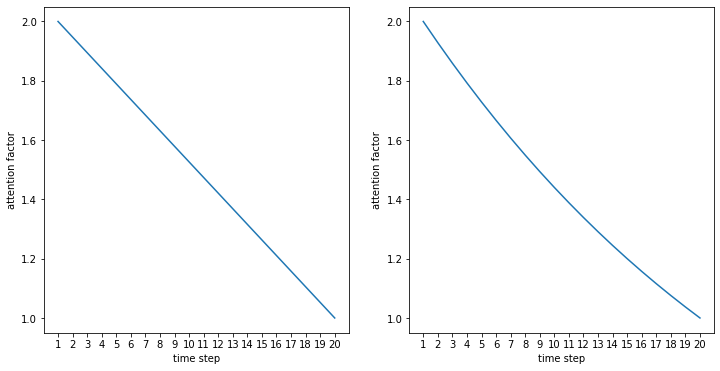

delta 2


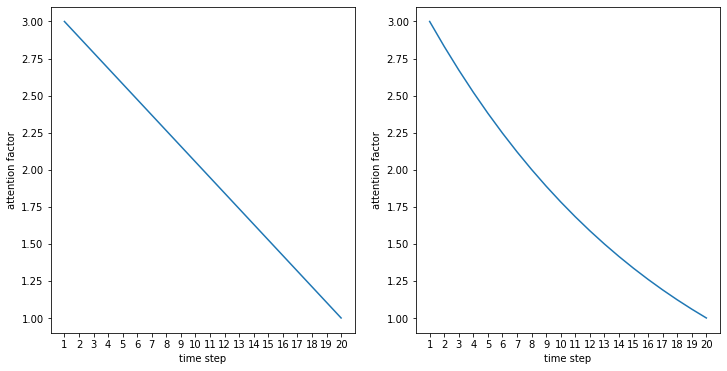

delta 3


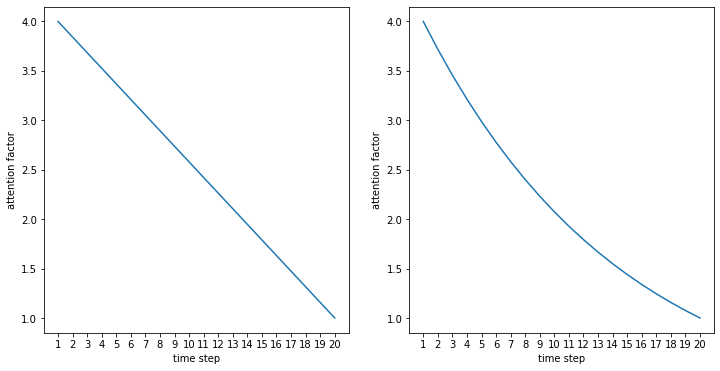

delta 4


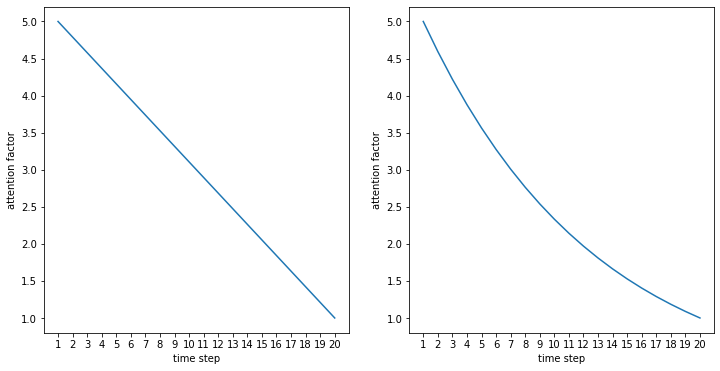

delta 5


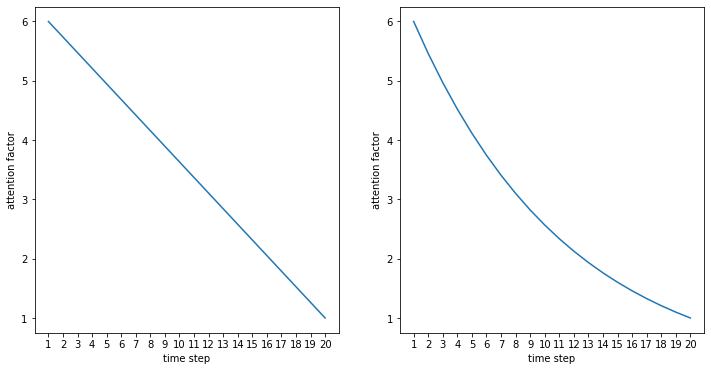

delta 6


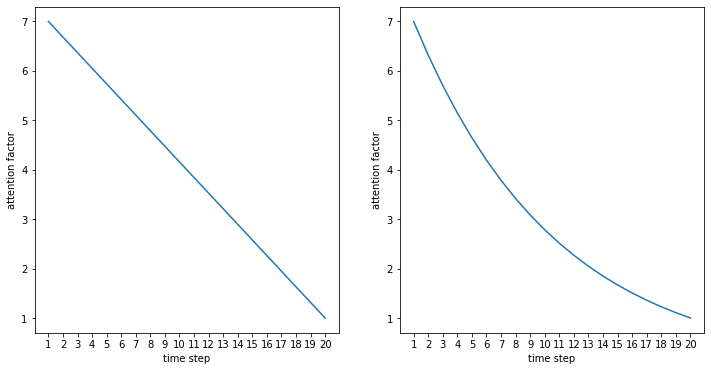

delta 7


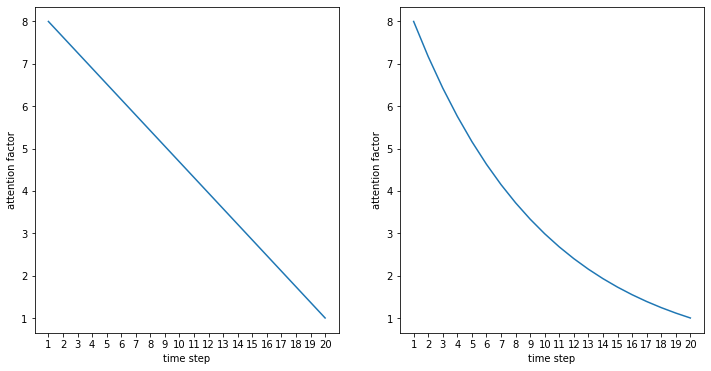

delta 8


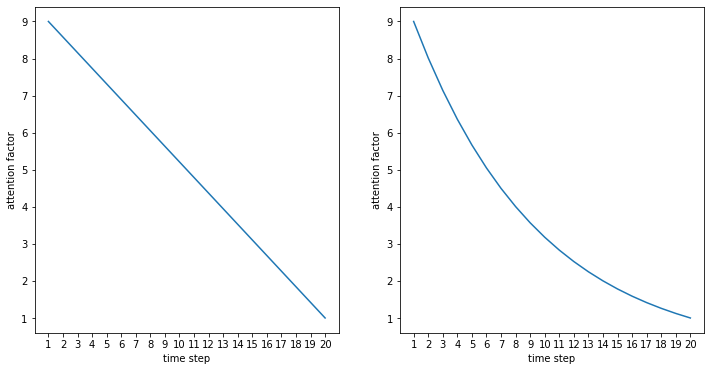

delta 9


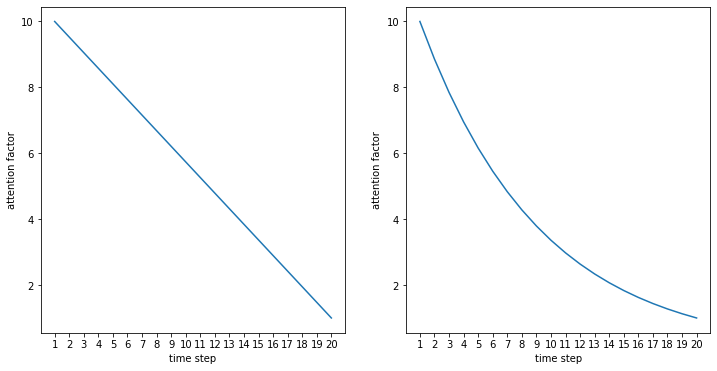

In [45]:
from src import rnn
import matplotlib.pyplot as plt

delta_list = [x for x in range(1,10)]
for delta in delta_list:
    linear_attention = rnn.super_attention(delta, future_length, 'linear')
    exp_attention = rnn.super_attention(delta, future_length, 'exp')
    
    print(f"delta {delta}")
    plt.figure(figsize=(12,6))
    
    plt.subplot(1,2,1)
    plt.plot([x for x in range(1,future_length+1)], linear_attention[0,:,0])
    plt.xlabel("time step")
    plt.xticks([x for x in range(1,future_length+1)])
    plt.ylabel("attention factor")
    
    plt.subplot(1,2,2)
    plt.plot([x for x in range(1,future_length+1)], exp_attention[0,:,0])
    plt.xlabel("time step")
    plt.xticks([x for x in range(1,future_length+1)])
    plt.ylabel("attention factor")
    
    plt.show()


## rnn model